<a href="https://colab.research.google.com/github/Yeonsu-Hong/Aiffel_Daegu_AI_project/blob/master/220210_exp11_stock_prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

exp11. 주가 예측하기

In [1]:
# 진행 하기 전에 statsmodels 업데이트가 필요하다.

In [ ]:
# No module named 'statsmodels.tsa.arima' error 메시지 뜸 arima 패키지를 사용하려면 업뎃이 필요!
# 버전 확인후 upgrade 진행

In [2]:
!pip freeze | grep "statsmodels" # 버전 확인!

statsmodels==0.10.2


In [3]:
!pip install --upgrade statsmodels # 진행후 runtime 다시 해야 한다.

     |████████████████████████████████| 9.8 MB 12.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [4]:
!pip freeze | grep "statsmodels" # 버전 확인! # 버전 업그레이드 확인! 

statsmodels==0.13.2


프로젝트 시작!

야후 finance (미국 사이트)에서 csv파일을 다운 받은후에 주식 시레르 예측한다.

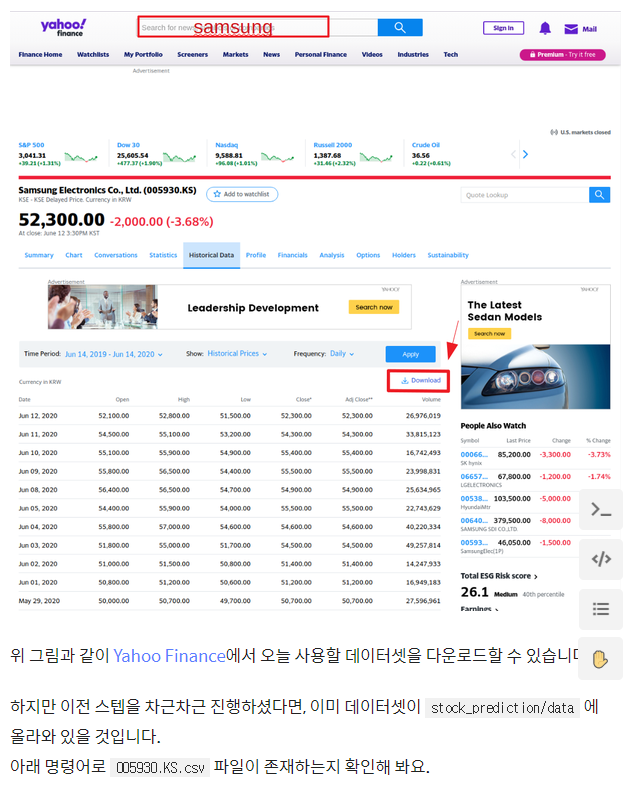

In [5]:
# 우선 csv 파일을 넣을 폴더를 구성
!mkdir -p ~/aiffel/stock_prediction/data

# 메뉴얼로 data파일안에 KS.csv 파일 넣기

In [6]:
# 초기 라이브러리 import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# os 모듈은 운영체제에서 제공되는 여러 기능을 파이썬에서 수행할 수 있게 해준다.

import warnings
warnings.filterwarnings('ignore')


In [7]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

**STEP2. 각종 전처리 수행**

1. 결측치 처리
2. 로그 변환

In [8]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [9]:
# 로그 변환 시도 
ts_log = np.log(ts)

**STEP 3. 시계열 안정성 분석**

1. 정성적 그래프 분석
2. 정량적 Augmented Dicky-Fullter Test
3. 시계열 분해(Time Series Decomposition)
4. Resudual 안정성 확인

In [11]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [13]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

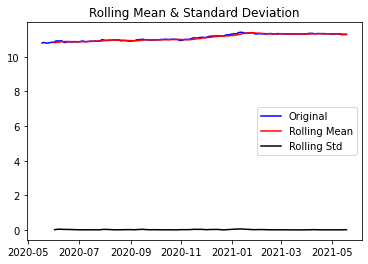

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


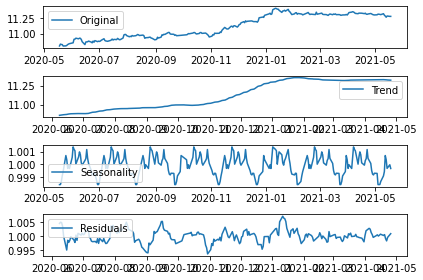

In [14]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [15]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


STEP 4. 학습, 테스트 데이터셋 생성

학습, 테스트 데이터셋 분리

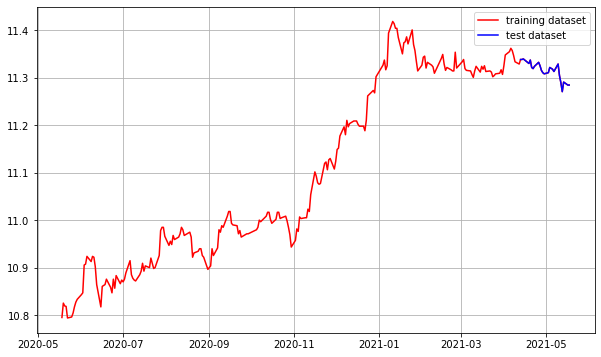

In [16]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


**STEP 5. 적정 ARIMA 모수 찾기**

ACF, PACF 그려보기 -> p,q 구하기
차분 안정성 확인 -> d 구하기

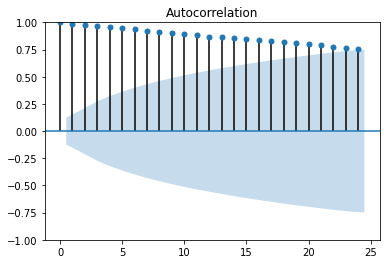

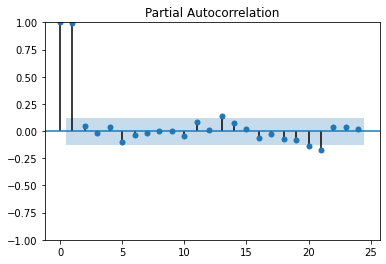

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


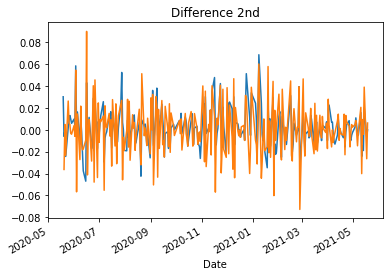

In [18]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

STEP 6. ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련

모델 테스트 및 플로팅

최종 예측 모델 정확도 측정 (MAPE)

In [19]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 17 Feb 2022   AIC                          -1156.722
Time:                        06:19:58   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


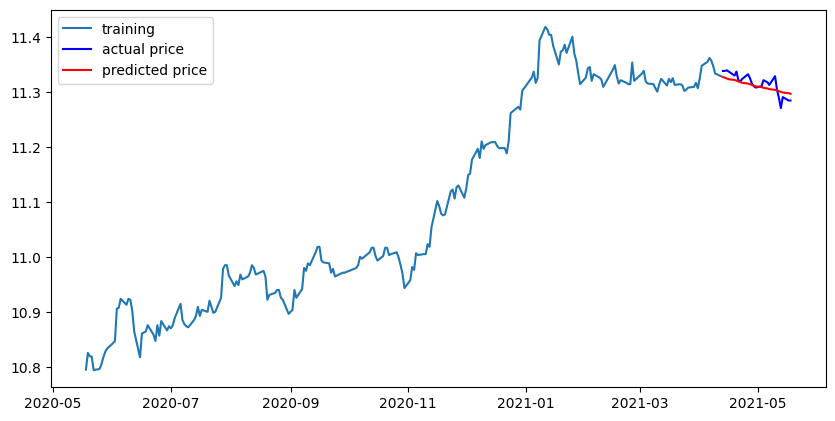

In [20]:
# Forecast : 결과가 fc에 담는다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100)) # 정확도를 오차의 백분율로 표시한다. 예를 들어 MAPE가 1.03%라면 예측값은 평균 1% 벗어난다. 낮을수록 좋음

MSE:  1048973.6014240563
MAE:  843.7579531508993
RMSE:  1024.194122920092
MAPE: 1.03%


**STEP 7. 다른 주식 종목 예측해 보기**

다른 종목으로 과정을 반복하며 fine tunning으로 조절해본다.

첫번째 종목 : 현대차

선정 이유: 지속적인 우상향하는 삼성전자와는 다르게 10년 주기 패턴으로 등락폭이 들쭉날쭉하다. 하지만, 20년 4월 코로나 사태 이후에 애플카 협업, 반도체 수급 부족등의 이유로 주가가 크게 올랐다가 내리는 형국으로 현재도 주가가 빠져나가고 있는데, 이것이 예측이 되는것인지 궁금하고 MAPE 결과도 알아보고 싶었다.

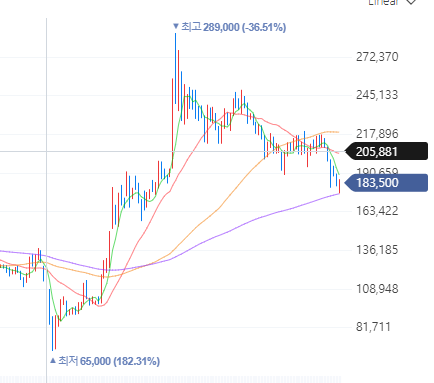

20년 3월 20일 이미 최저가를 찍은 상황이었다.

이 시점을 기준으로 다운로드! 

야후 파이낸스에서는 기간을 설정하여 csv파일을 다운로드 할수 있다.

In [24]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005380.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-03-20    71100.0
2020-03-23    68900.0
2020-03-24    74800.0
2020-03-25    84500.0
2020-03-26    84900.0
Name: Close, dtype: float64

In [25]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [26]:
# 로그 변환 시도 
ts_log = np.log(ts)

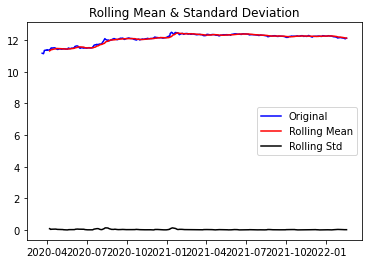

Results of Dickey-Fuller Test:
Test Statistic                  -3.441089
p-value                          0.009635
#Lags Used                       1.000000
Number of Observations Used    470.000000
Critical Value (1%)             -3.444340
Critical Value (5%)             -2.867709
Critical Value (10%)            -2.570056
dtype: float64


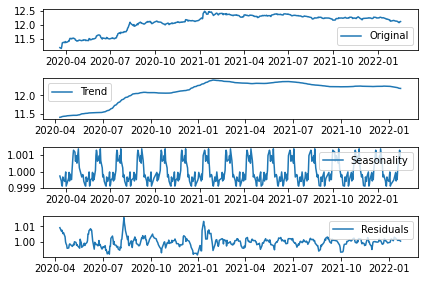

In [27]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [28]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -8.198903e+00
p-value                        7.320928e-13
#Lags Used                     2.000000e+00
Number of Observations Used    4.390000e+02
Critical Value (1%)           -3.445334e+00
Critical Value (5%)           -2.868146e+00
Critical Value (10%)          -2.570289e+00
dtype: float64


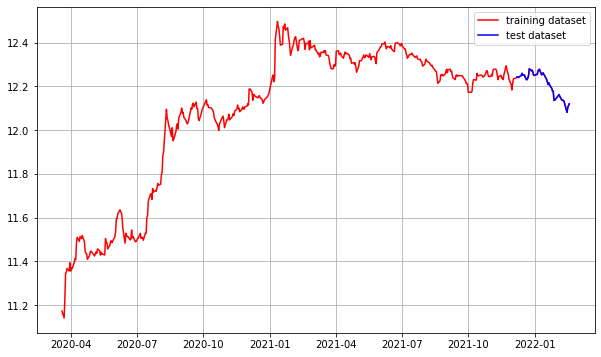

In [29]:
# 학습, 테스트 데이터셋 생성

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

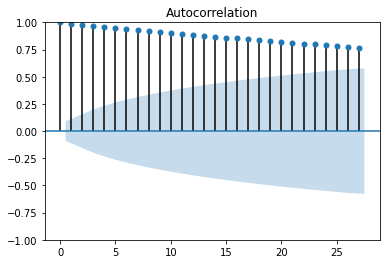

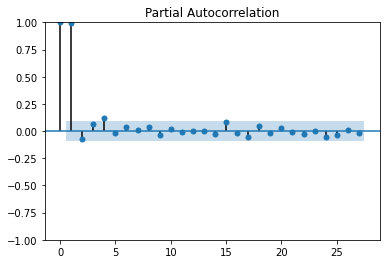

In [30]:
# ACF, PACF 그려보기 -> p, q 구하기

# 차분 안정성 확인 -> d 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -19.484546
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    470.000000
Critical Value (1%)             -3.444340
Critical Value (5%)             -2.867709
Critical Value (10%)            -2.570056
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.113494e+01
p-value                        3.212858e-20
#Lags Used                     1.400000e+01
Number of Observations Used    4.550000e+02
Critical Value (1%)           -3.444804e+00
Critical Value (5%)           -2.867913e+00
Critical Value (10%)          -2.570165e+00
dtype: float64


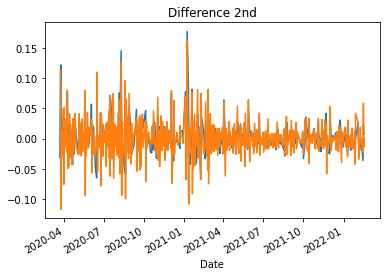

In [31]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [51]:
# ARIMA 모델 빌드와 훈련
# 모델 테스트 및 플로팅
# 최종 MAPE 측정 (예측 모델 정확도 측정)

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(5, 0, 1))  # 첫번째 p값 세번째 d값 바꾸어가면서 최적화 해보기
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  424
Model:                 ARIMA(5, 0, 1)   Log Likelihood                 949.976
Date:                Thu, 17 Feb 2022   AIC                          -1883.952
Time:                        06:45:12   BIC                          -1851.554
Sample:                             0   HQIC                         -1871.152
                                - 424                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7260      0.334     35.120      0.000      11.072      12.380
ar.L1          0.2913      0.679      0.429      0.668      -1.039       1.621
ar.L2          0.8150      0.733      1.112      0.2

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


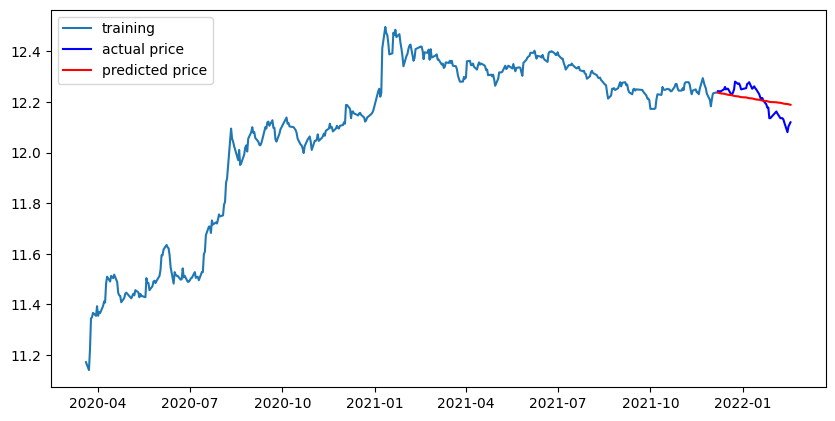

In [52]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [53]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  81207240.16674511
MAE:  7550.476768380972
RMSE:  9011.505987721759
MAPE: 3.83%


In [ ]:
# 위의 코드에서

# model = ARIMA(train_data, order=(5, 0, 1))  # 첫번째 p값 세번째 d값 바꾸어가면서 최적화 해보기


p값과 d값을 바꾸어보니 MAPE가 5%대에서 3.83%로 떨어지는 것을 볼수 있었다.

q값은 0인데, 위의 시계열 데이터는 AR의 경향성만 가지는 것으로 보이기 때문이었다.

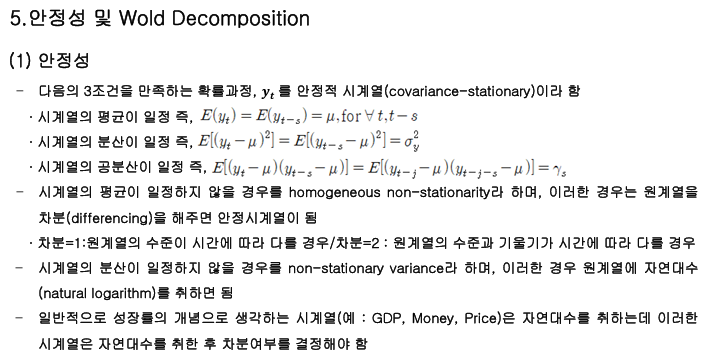

차분 값을 바꾸면 안정시계열이 된다고 기술하고 있지만, 정확히 어떠한 것을 의미하는지는 솔직히 감이 잡히지 않는다.

우선은 다른 MAPE가 15% 미만이라 다른 종목으로 넘어가보려고 한다.

두번째 종목 : 신풍제약

선정 이유: 한국의 대표적인 잡스러운 바이오 종목의 전형적인 성향을 나타내는 주식이다.

중국 우한에서 유래한 코로나 바이러스 사태가 터지면서 백신과 치료제를 찾는 움직임들이 발생하였고, 우리나라에서는 
mRNA 백신 원천 기술을 가진 기업들이 없어서 대표적인 바이오 제약회사중 하나인 
셀트리온 코로나 항체 치료제 레키로나주 그리고 완전 중소기업이었던 신풍제약에서는 피라맥스라고 하는 치료제가 약물재창출로 발견되어 임상까지 가면서 기대 심리로 엄청나게 폭등을 하였다. 현재는 완전히 거품이 빠진 단계인데, 사실 예측 불허한 이러한 종목의 분석결과 또한 궁금하여서 선정하였다. 



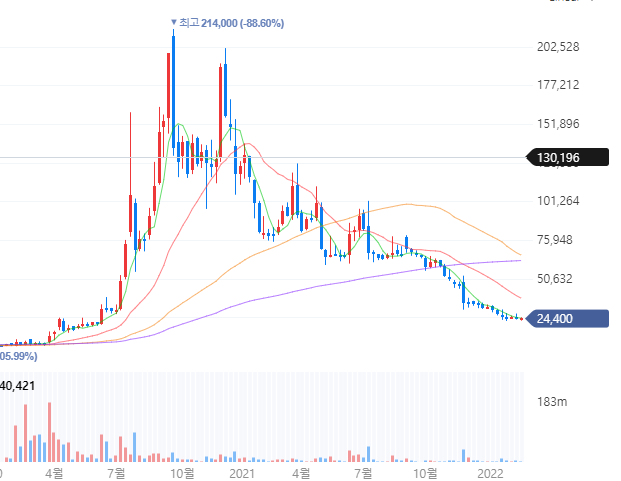

2020년 4월 이후에 거래량이 증가하기 시작하더니 10월전에 최고가를 경신하였다. 
(35배 상승 -> 1억 넣었으면 35억이 되는 수치!)

임상 3상 실패등 약효과 없다는 뉴스가 나오면서 줄줄 흐르기 시작하더니 24,400원이 되었다.
(21만원에 들어간 사람은 1000% 손실을 기록!)

In [54]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/019170.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-03-20     7880.0
2020-03-23     8340.0
2020-03-24     8550.0
2020-03-25     9610.0
2020-03-26    12450.0
Name: Close, dtype: float64

In [55]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [56]:
# 로그 변환 시도 
ts_log = np.log(ts)

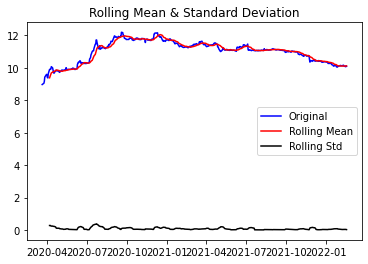

Results of Dickey-Fuller Test:
Test Statistic                  -2.664681
p-value                          0.080352
#Lags Used                       1.000000
Number of Observations Used    470.000000
Critical Value (1%)             -3.444340
Critical Value (5%)             -2.867709
Critical Value (10%)            -2.570056
dtype: float64


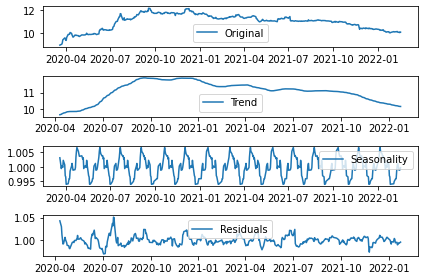

In [57]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [58]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -8.208368e+00
p-value                        6.925258e-13
#Lags Used                     1.200000e+01
Number of Observations Used    4.290000e+02
Critical Value (1%)           -3.445685e+00
Critical Value (5%)           -2.868301e+00
Critical Value (10%)          -2.570371e+00
dtype: float64


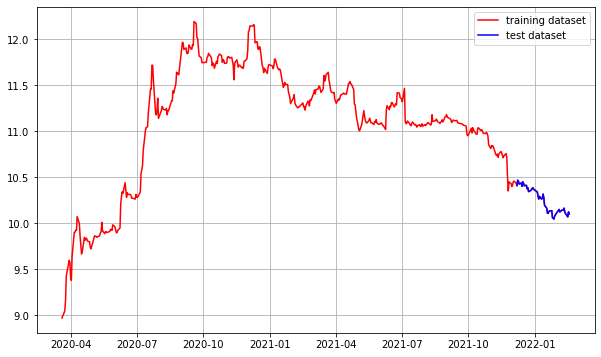

In [77]:
# 학습, 테스트 데이터셋 생성

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

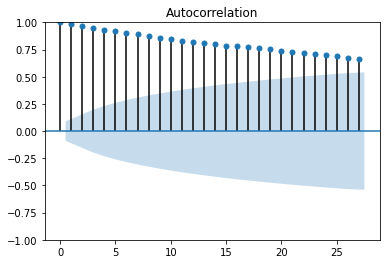

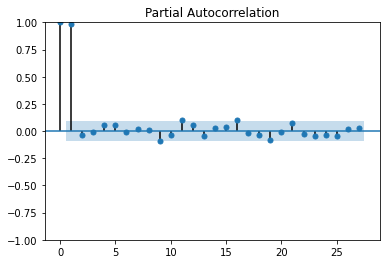

In [78]:
# ACF, PACF 그려보기 -> p, q 구하기

# 차분 안정성 확인 -> d 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -18.934266
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    470.000000
Critical Value (1%)             -3.444340
Critical Value (5%)             -2.867709
Critical Value (10%)            -2.570056
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.993988e+00
p-value                        6.772158e-15
#Lags Used                     1.700000e+01
Number of Observations Used    4.520000e+02
Critical Value (1%)           -3.444900e+00
Critical Value (5%)           -2.867956e+00
Critical Value (10%)          -2.570187e+00
dtype: float64


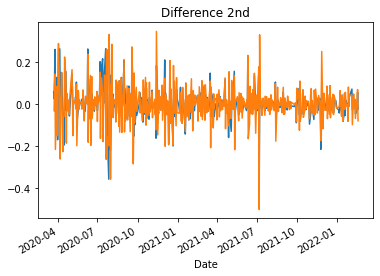

In [79]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [83]:
# ARIMA 모델 빌드와 훈련
# 모델 테스트 및 플로팅
# 최종 MAPE 측정 (예측 모델 정확도 측정)

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 0, 8))  # 첫번째 p값 세번째 d값 바꾸어가면서 최적화 해보기
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  424
Model:                ARIMA(14, 0, 8)   Log Likelihood                 520.875
Date:                Thu, 17 Feb 2022   AIC                           -993.750
Time:                        07:12:57   BIC                           -896.556
Sample:                             0   HQIC                          -955.349
                                - 424                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8839      1.548      7.033      0.000       7.851      13.917
ar.L1         -0.4363      3.036     -0.144      0.886      -6.387       5.514
ar.L2         -0.3025      0.903     -0.335      0.7

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


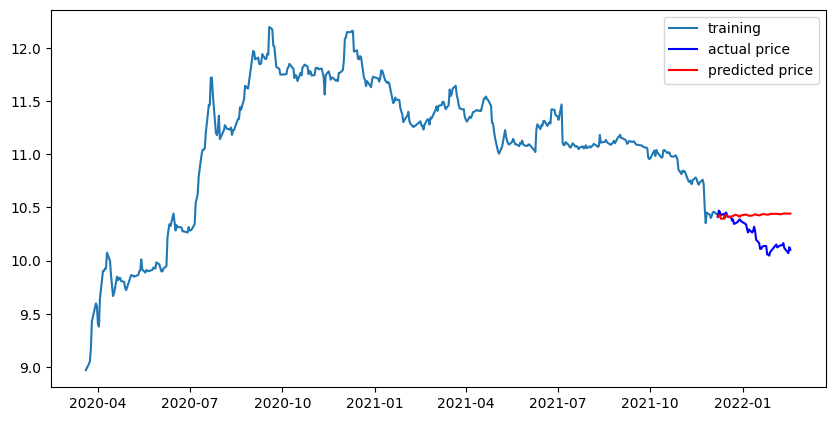

In [84]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [85]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  43732245.828533515
MAE:  5394.8886185038
RMSE:  6613.03605226325
MAPE: 20.97%


MAPE가 15% 넘어가는 20.97%가 나왔다. 개선 방향을 논하기 전에 다른 마지막 종목에 대한 분석을 해보고 개선방안을 생각해 보기로 하였다.

세번째 종목 : sk 하이닉스

선정 이유: 대표적인 우리나라의 시가총액 3등의 대기업으로, 
이 종목의 특징은 안정적으로 우상향하는 경향성이 있지만, 한편으로는 반도체 호황 싸이클을 타는 종목이다.


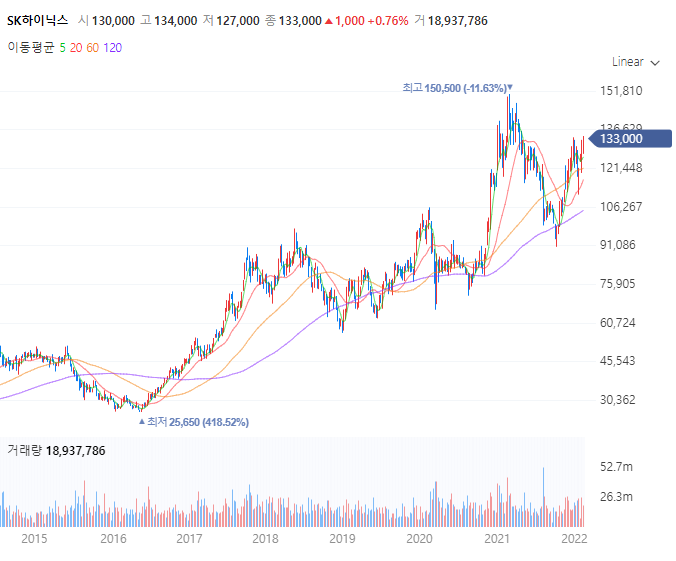


조금더 브로드 하게 보면 주봉 차트상 삼성전자와 같이 우상향하는 것을 알수 있다. 하지만 펜데믹 전에도 반도체 호황에 따라 차트가 뛰엇다가 가라앉음을 알수 있고, 대체적으로 120일선 붕괴후 한번씩 큰 상승이 있는 종목임을 알수 있다.

위의 2 종목과는 다르게 좀더 와이드하게 15년 1월부터 데이터를 넣어서 MAPE 및 prediction을 분석해보고자 한다.

In [86]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/000660.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2015-01-02    47750.0
2015-01-05    47650.0
2015-01-06    47500.0
2015-01-07    47400.0
2015-01-08    49950.0
Name: Close, dtype: float64

In [87]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [88]:
# 로그 변환 시도 
ts_log = np.log(ts)

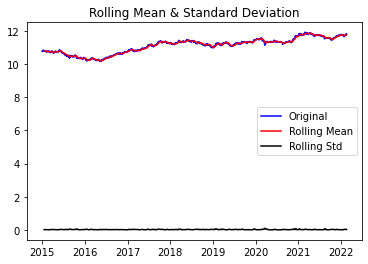

Results of Dickey-Fuller Test:
Test Statistic                   -0.548020
p-value                           0.882300
#Lags Used                        1.000000
Number of Observations Used    1750.000000
Critical Value (1%)              -3.434092
Critical Value (5%)              -2.863193
Critical Value (10%)             -2.567650
dtype: float64


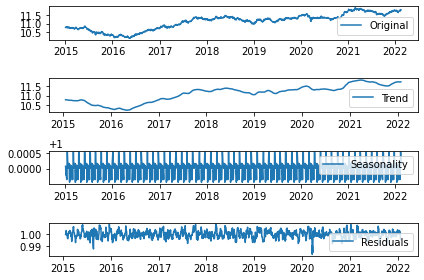

In [89]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [90]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.204760e+01
p-value                        2.642684e-22
#Lags Used                     2.200000e+01
Number of Observations Used    1.699000e+03
Critical Value (1%)           -3.434205e+00
Critical Value (5%)           -2.863243e+00
Critical Value (10%)          -2.567676e+00
dtype: float64


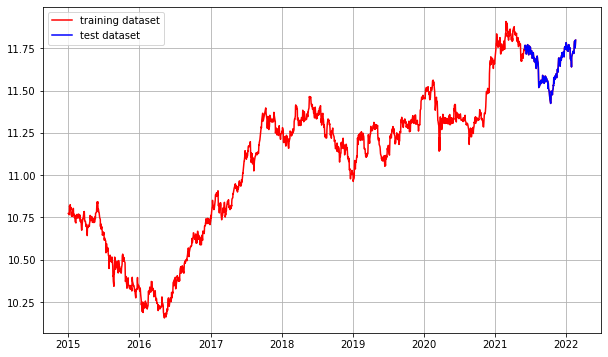

In [91]:
# 학습, 테스트 데이터셋 생성

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

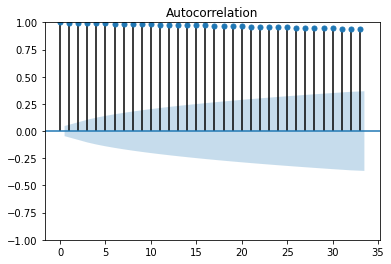

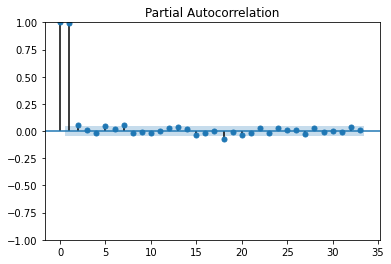

In [92]:
# ACF, PACF 그려보기 -> p, q 구하기

# 차분 안정성 확인 -> d 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -44.011418
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1750.000000
Critical Value (1%)              -3.434092
Critical Value (5%)              -2.863193
Critical Value (10%)             -2.567650
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.391553e+01
p-value                        5.412306e-26
#Lags Used                     2.400000e+01
Number of Observations Used    1.725000e+03
Critical Value (1%)           -3.434147e+00
Critical Value (5%)           -2.863217e+00
Critical Value (10%)          -2.567663e+00
dtype: float64


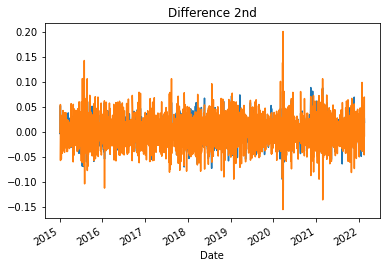

In [93]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [94]:
# ARIMA 모델 빌드와 훈련
# 모델 테스트 및 플로팅
# 최종 MAPE 측정 (예측 모델 정확도 측정)

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(5, 0, 1))  # 첫번째 p값 세번째 d값 바꾸어가면서 최적화 해보기
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1576
Model:                 ARIMA(5, 0, 1)   Log Likelihood                3715.212
Date:                Thu, 17 Feb 2022   AIC                          -7414.425
Time:                        07:26:15   BIC                          -7371.523
Sample:                             0   HQIC                         -7398.482
                               - 1576                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0409      1.248      8.850      0.000       8.596      13.486
ar.L1          0.6375      0.712      0.896      0.370      -0.757       2.032
ar.L2          0.3514      0.669      0.525      0.6

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


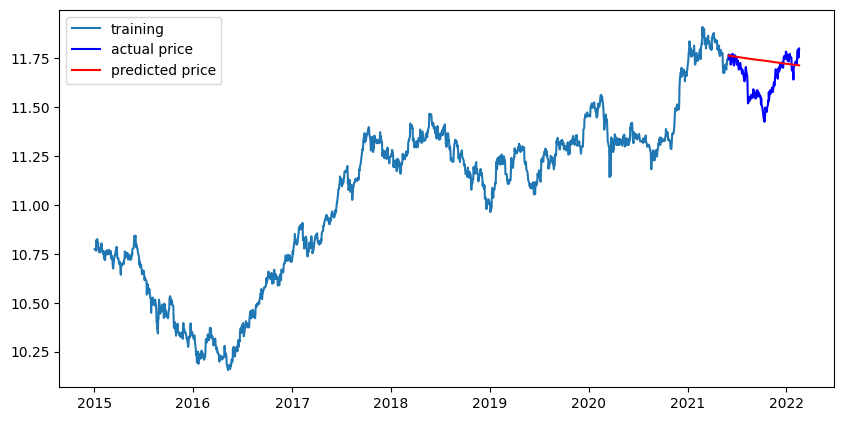

In [95]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [96]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  209834105.66403818
MAE:  11249.247957325853
RMSE:  14485.651716924516
MAPE: 10.55%


MAPE 값이 10.55%로 plot된 prediction을 보더라도 급락했던 폭을 생각해본다면, 얼추 양상자체가 비슷하다고 할수 없지만, 통계적으로도 의미있는 graph가 나왔다고 생각한다.

다른 종목을 추가적으로 해보고, 신풍 제약같은 경우에는 기간을 브로드하게 잡아서 한번 해보고 개선방안을 생각해봐야겠다.

네번째 종목 : LG화학

선정 이유: LG 화학 같은 경우에는 주가가 계속 제자리를 못 벗어나다가 펜데믹과 탄소중립 정책에 수혜를 받아서 전기차 배터리 점유율을 높이고 적자에서 흑자전환이 일어나면서 단기간 급등한 종목이다. 하지만, 얼마전 인적분할로 lG배터리 솔루션이 분사해나가면서 지속적으로 주가가 떨어지고 있는 암울한 종목이다. 좀더 브로드 하게 잡아서 분석을 해보고 싶었다.

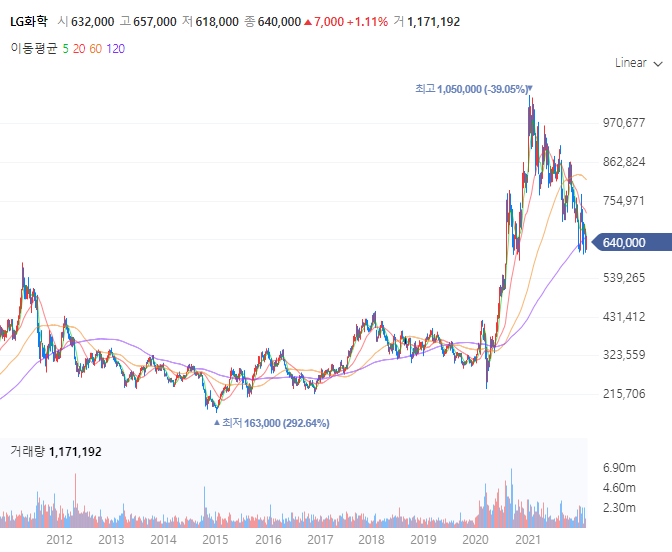

In [97]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/051910.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2014-01-02    292000.0
2014-01-03    286000.0
2014-01-06    284500.0
2014-01-07    277500.0
2014-01-08    275000.0
Name: Close, dtype: float64

In [99]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

# 로그 변환 시도 
ts_log = np.log(ts)

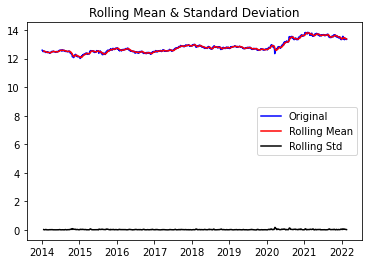

Results of Dickey-Fuller Test:
Test Statistic                   -0.990305
p-value                           0.756784
#Lags Used                        0.000000
Number of Observations Used    1996.000000
Critical Value (1%)              -3.433630
Critical Value (5%)              -2.862989
Critical Value (10%)             -2.567541
dtype: float64


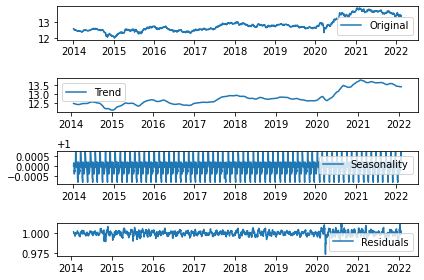

In [100]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [101]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.337486e+01
p-value                        5.112216e-25
#Lags Used                     2.600000e+01
Number of Observations Used    1.940000e+03
Critical Value (1%)           -3.433725e+00
Critical Value (5%)           -2.863031e+00
Critical Value (10%)          -2.567564e+00
dtype: float64


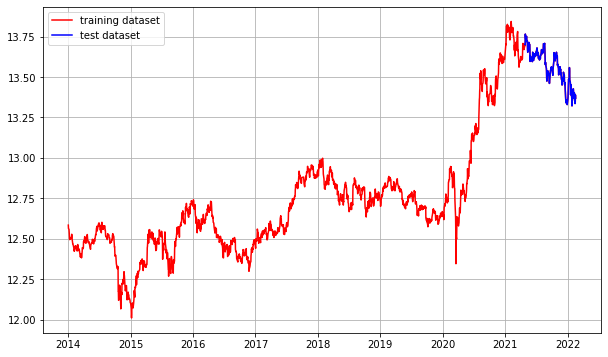

In [102]:
# 학습, 테스트 데이터셋 생성

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

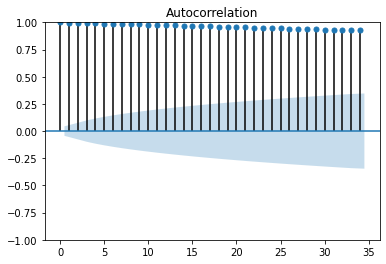

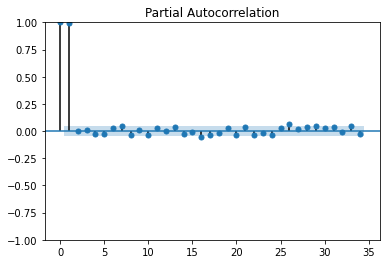

In [103]:
# ACF, PACF 그려보기 -> p, q 구하기

# 차분 안정성 확인 -> d 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.717000e+01
p-value                        6.753284e-30
#Lags Used                     6.000000e+00
Number of Observations Used    1.989000e+03
Critical Value (1%)           -3.433642e+00
Critical Value (5%)           -2.862994e+00
Critical Value (10%)          -2.567544e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.619463e+01
p-value                        4.136636e-29
#Lags Used                     2.200000e+01
Number of Observations Used    1.972000e+03
Critical Value (1%)           -3.433670e+00
Critical Value (5%)           -2.863007e+00
Critical Value (10%)          -2.567551e+00
dtype: float64


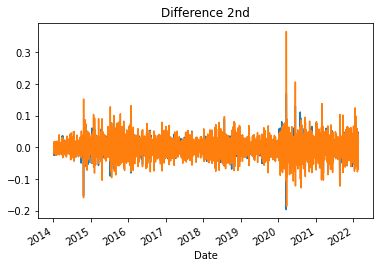

In [104]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [105]:
# ARIMA 모델 빌드와 훈련
# 모델 테스트 및 플로팅
# 최종 MAPE 측정 (예측 모델 정확도 측정)

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(5, 0, 1))  # 첫번째 p값 세번째 d값 바꾸어가면서 최적화 해보기
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1797
Model:                 ARIMA(5, 0, 1)   Log Likelihood                4150.663
Date:                Thu, 17 Feb 2022   AIC                          -8285.327
Time:                        07:34:28   BIC                          -8241.376
Sample:                             0   HQIC                         -8269.101
                               - 1797                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7189      1.495      8.506      0.000       9.788      15.650
ar.L1          0.6620      0.861      0.769      0.442      -1.025       2.349
ar.L2          0.3493      0.847      0.412      0.6

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


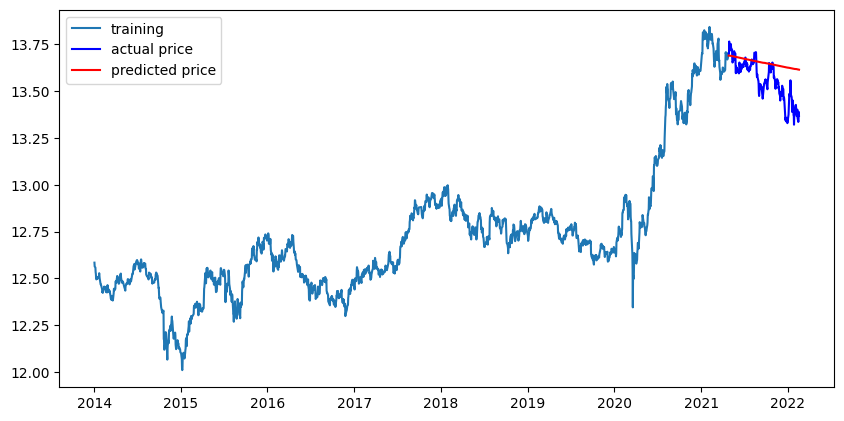

In [106]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [107]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  9087213338.47568
MAE:  76378.15150244196
RMSE:  95326.8762651734
MAPE: 10.67%


별다른 파라미터 튜닝없이 MAPE가 10.67%가 나왔다.

training data가 커져서 그럴수도 있다고 생각이 들어서 신풍제약 데이터 같은 경우 10년치를 끌어 모아서 한번 더 prediction을 해보기로 하였다. 

In [108]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/019171.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2012-01-02    4302.701172
2012-01-03    4302.701172
2012-01-04    4320.480957
2012-01-05    4649.406250
2012-01-06    4916.102539
Name: Close, dtype: float64

In [109]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [110]:
# 로그 변환 시도 
ts_log = np.log(ts)

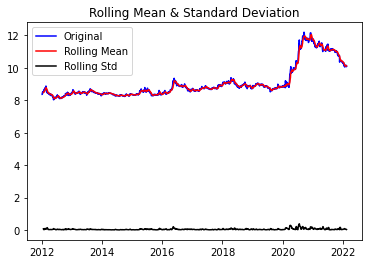

Results of Dickey-Fuller Test:
Test Statistic                   -0.955565
p-value                           0.769124
#Lags Used                       24.000000
Number of Observations Used    2467.000000
Critical Value (1%)              -3.433003
Critical Value (5%)              -2.862712
Critical Value (10%)             -2.567394
dtype: float64


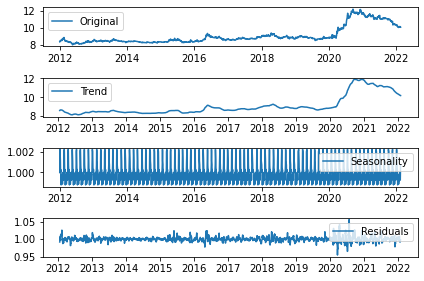

In [111]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [112]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.446935e+01
p-value                        6.644893e-27
#Lags Used                     2.500000e+01
Number of Observations Used    2.436000e+03
Critical Value (1%)           -3.433037e+00
Critical Value (5%)           -2.862727e+00
Critical Value (10%)          -2.567402e+00
dtype: float64


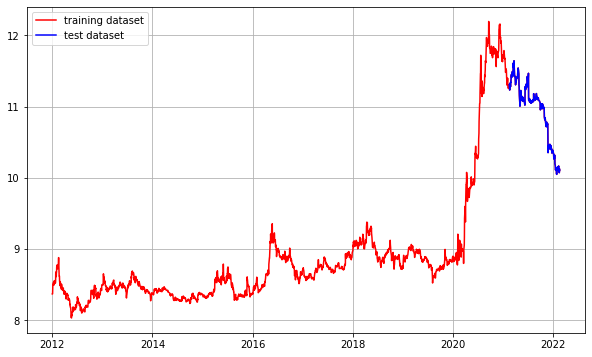

In [113]:
# 학습, 테스트 데이터셋 생성

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

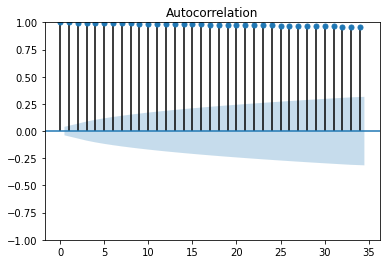

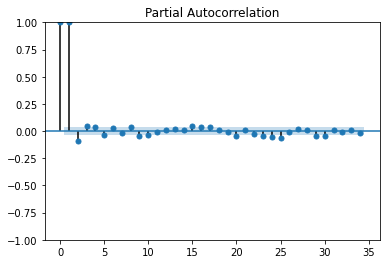

In [114]:
# ACF, PACF 그려보기 -> p, q 구하기

# 차분 안정성 확인 -> d 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.158464e+00
p-value                        2.571352e-15
#Lags Used                     2.300000e+01
Number of Observations Used    2.467000e+03
Critical Value (1%)           -3.433003e+00
Critical Value (5%)           -2.862712e+00
Critical Value (10%)          -2.567394e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.766325e+01
p-value                        3.673731e-30
#Lags Used                     2.700000e+01
Number of Observations Used    2.462000e+03
Critical Value (1%)           -3.433009e+00
Critical Value (5%)           -2.862715e+00
Critical Value (10%)          -2.567395e+00
dtype: float64


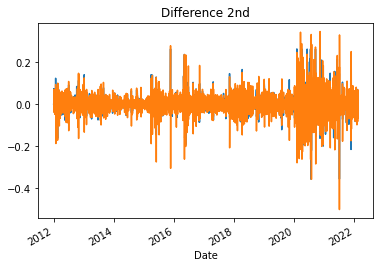

In [115]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [122]:
# ARIMA 모델 빌드와 훈련
# 모델 테스트 및 플로팅
# 최종 MAPE 측정 (예측 모델 정확도 측정)

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 0, 8))  # 첫번째 p값 세번째 d값 바꾸어가면서 최적화 해보기
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2242
Model:                ARIMA(14, 0, 8)   Log Likelihood                4023.454
Date:                Thu, 17 Feb 2022   AIC                          -7998.908
Time:                        07:43:08   BIC                          -7861.745
Sample:                             0   HQIC                         -7948.835
                               - 2242                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9021      0.956      9.311      0.000       7.028      10.776
ar.L1         -0.4827      1.249     -0.386      0.699      -2.931       1.966
ar.L2         -0.4591      0.863     -0.532      0.5

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


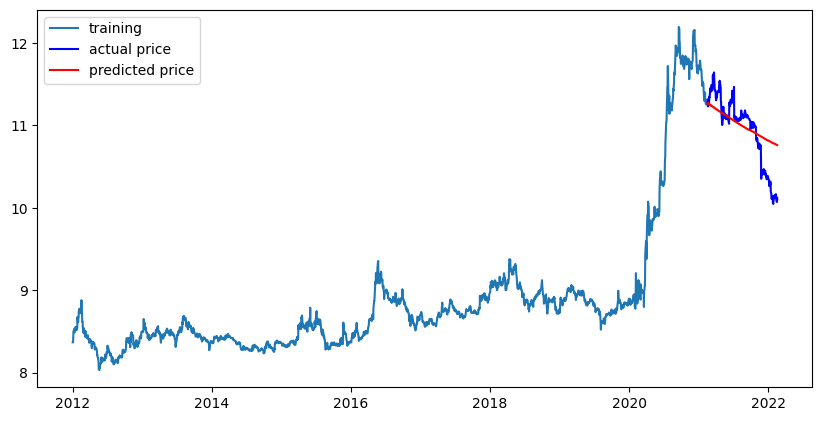

In [123]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [124]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  220409310.53516424
MAE:  11985.554110379193
RMSE:  14846.188417744273
MAPE: 25.51%


p값을 2에서 14로 변경하며 d값도 1에서 8로 바꾸니 10%정도 하향한 25%가 나왔다.

MAPE값과는 별개로 prediction plot은 어느정도 신빙성이 있는 그래프가 plot이 되었다.

현재의 지식으로는 신풍제약과 같이 급등락하는 종목에 대한 특성이 아닐까라는 생각이 든다.

러닝 타임이 얼마 걸리지 않아서 또다른 양상의 종목인 한개의 종목을 더해보고 신풍제약 데이터를 보완후에 끝내려고 한다. 

마지막 종목 : KB금융

금융주로 금리인상이 되면 덩달아 상승하는 종목이다.
펜데믹 이후로 지속 우상향중인 종목이다.



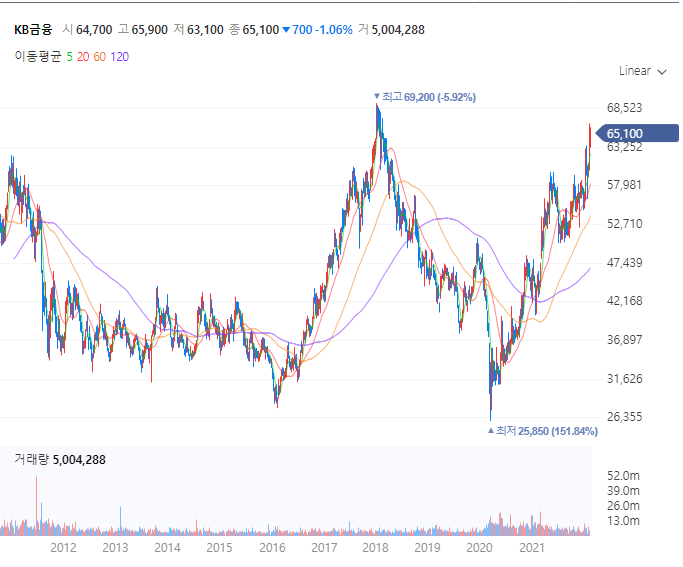

In [126]:
# /root/aiffel/stock_prediction/data/323990.KQ.csv

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/KB.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2012-01-03    32.450001
2012-01-04    32.049999
2012-01-05    31.959999
2012-01-06    31.139999
2012-01-09    30.980000
Name: Close, dtype: float64

In [127]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [128]:
# 로그 변환 시도 
ts_log = np.log(ts)

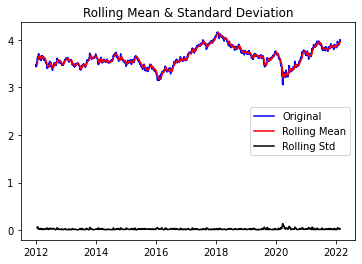

Results of Dickey-Fuller Test:
Test Statistic                   -1.861146
p-value                           0.350554
#Lags Used                        9.000000
Number of Observations Used    2539.000000
Critical Value (1%)              -3.432928
Critical Value (5%)              -2.862679
Critical Value (10%)             -2.567376
dtype: float64


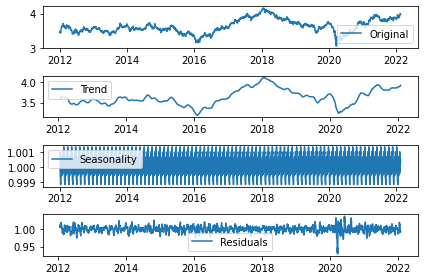

In [129]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [130]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.403230e+01
p-value                        3.417495e-26
#Lags Used                     2.400000e+01
Number of Observations Used    2.494000e+03
Critical Value (1%)           -3.432975e+00
Critical Value (5%)           -2.862700e+00
Critical Value (10%)          -2.567387e+00
dtype: float64


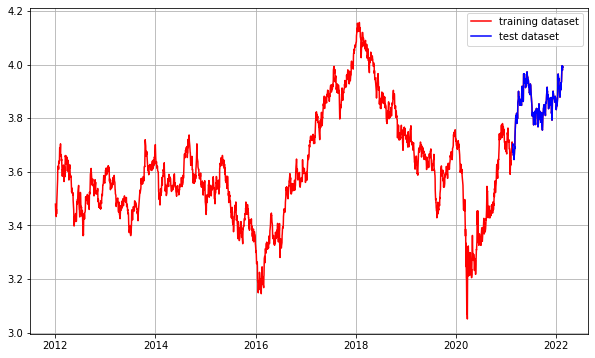

In [131]:
# 학습, 테스트 데이터셋 생성

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

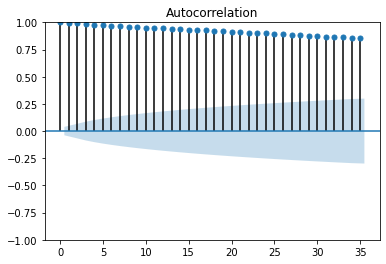

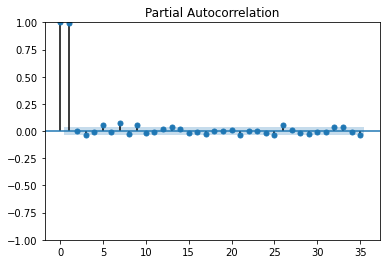

In [132]:
# ACF, PACF 그려보기 -> p, q 구하기

# 차분 안정성 확인 -> d 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.745707e+01
p-value                        4.618981e-30
#Lags Used                     8.000000e+00
Number of Observations Used    2.539000e+03
Critical Value (1%)           -3.432928e+00
Critical Value (5%)           -2.862679e+00
Critical Value (10%)          -2.567376e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.705489e+01
p-value                        8.021810e-30
#Lags Used                     2.700000e+01
Number of Observations Used    2.519000e+03
Critical Value (1%)           -3.432949e+00
Critical Value (5%)           -2.862688e+00
Critical Value (10%)          -2.567381e+00
dtype: float64


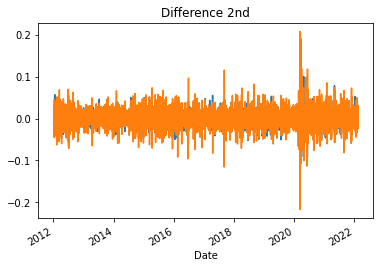

In [133]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [137]:
# ARIMA 모델 빌드와 훈련
# 모델 테스트 및 플로팅
# 최종 MAPE 측정 (예측 모델 정확도 측정)

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 0, 9))  # 첫번째 p값 세번째 d값 바꾸어가면서 최적화 해보기
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2294
Model:                ARIMA(14, 0, 9)   Log Likelihood                5898.333
Date:                Thu, 17 Feb 2022   AIC                         -11746.666
Time:                        08:10:31   BIC                         -11603.214
Sample:                             0   HQIC                        -11694.358
                               - 2294                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6029      0.068     52.751      0.000       3.469       3.737
ar.L1         -0.1134      1.236     -0.092      0.927      -2.535       2.309
ar.L2         -0.1385      1.353     -0.102      0.9

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


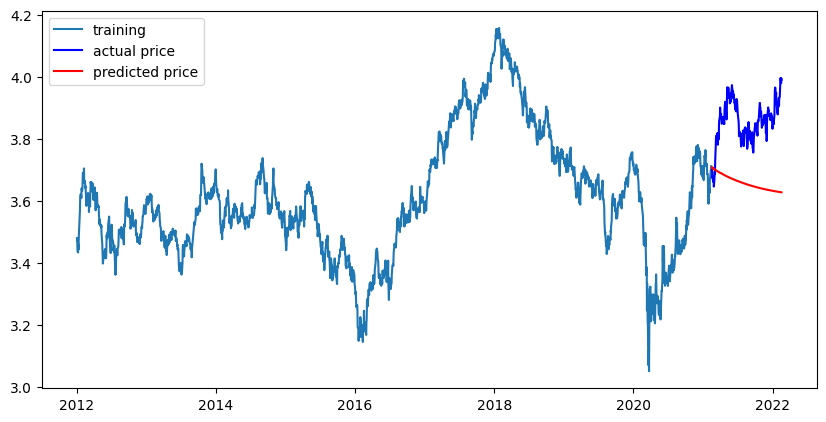

In [138]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [139]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  85.84157709149623
MAE:  8.662914085961996
RMSE:  9.265072967413492
MAPE: 17.92%


마지막으로 진행을 했으나 아쉽게도 15% 밑으로 낮추지는 못하였다.


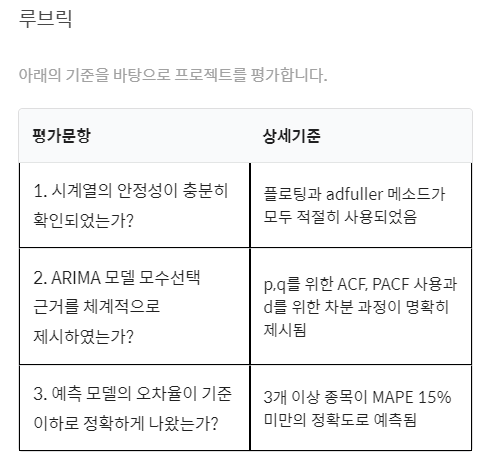

평가 문항 3개 모두 충족하였고, 
예시종목 삼성전자 이외에 SK 하이닉스, 현대차, LG 화학은 각각 15% 미만의 기준을 충족하였다.



In [ ]:
# 삼성 전자

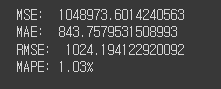

In [140]:
# SK 하이닉스

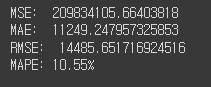

In [ ]:
# 현대차

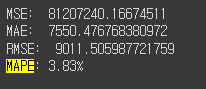

In [141]:
# LG 화학

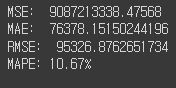

회고 및 결론:

이번 실습은 금융 데이터를 토대로 예측하는 모델이었다.

사실 예측이라기 보다는 수열의 특징을 가지고 규칙을 찾아서 마지막 항이 어떤 수치로 나올지 확인하는 전형적인 금융공학의 내용이었다.

개론으로서 아주 재미있는 exploration 이었으나, 뭔가가 조금 아쉽고 사실 한학기의 내용을 단시간에 1주일만에 다 알기에는 무리가 있었다.

그리고 결과를 봐서 알겠지만, 코스피 상위권에 있는 종목들은 MAPE값이 15% 미만이 나왔는데, 정확도가 훨씬 높다는 것을 의미했다. 전반적으로 보았을때 여러가지 변수들도 작용을 하지만, 지속 우상향이라는 패턴을 가지고 있기에 이 정도의 수치가 나오지 않았나 생각이 든다.

시간을 좀더 투자해서 면밀히 뜯어보고 여러가지 변수를 바꾸면서 나만의 프로그램을 만들어 보고 싶지만, 제한된 시간으로 인해서 아쉬운 exploration이었다.

그리고 확실한 것은 이러한 모델들이 높은 정확성을 가질수 없는 것이 주가에 영향을 주는 변수는 너무나도 많다. (국제유가, 인플레이션, 전쟁, 전염병 전파 등등)
위와 같은 외부적인 변수 이외에도 각 국가별 잘못된 경제정책의 여파도 있고..

만약 이러한 모델들이 성공을 했으면 지금 전세계 대다수의 부를 누리는 사람들은 금융공학을 전공한 교수들과 금융인들이 되었을터.. 전혀 그렇지가 않다.

단순히 참조용으로는 소용이 있겠으나, 부의 축적을 위해서 이러한 모델을 쓴다면 굉장히 회의적일수 밖에 없겠다.

위의 예시에서 박셀바이오, 신풍제약과 같은 한치앞을 내다볼수도 없는 당장 내일모레 상장폐지가 되어도 안 이상할 주식종목들은 온갖 최신 기법의 차트분석을 통한 예측 자체가 아예 불가능하다라는 생각도 든다.

스트레스 없이 아주 재미있게 통계적 지식까지 쌓을수 있었던 주제였지만, 금융공학의 개론수준의 지식만을 교양차원에서 습득했다는 생각만 들었고, 이를 발전시켜 활용해서 CNN과 시계열 지식, LSTM 등을 활용하여 부를 쌓겠다는 생각을 원천 봉쇄시켜 버린 주제였다.



p.s 시간이 된다면 웹 크롤링을 빨리 배우고 싶다. MAPE 데이터 일일이 찾는다고 힘들었다.